In [2]:
import rasterio
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.colors import ListedColormap
import pandas as pd
import seaborn as sns

## Cargar datos

La imagen de referencia para el desarrollo del ejercicio, fue obtenida de https://browser.dataspace.copernicus.eu/, la referencia de la imagen es S2A_MSIL2A_20240125T151711_N0510_R125_T18NYM_20240125T180053, generada el 2024-01-25T18:00:53.000000Z, con huella en coordenadas 6.329895366889834 -73.19235572325684 6.325495026737362 -72.20042267993938 5.33339430132316 -72.20533884985993 5.337100278069697 -73.19553295981748 6.329895366889834 -73.19235572325684.

Partiendo de la imagen base, usando el software SNAP, se realizaron las siguientes operaciones:
-	remuestreo (raster/geometric/resampling) empleando la banda 4 (10 metros por píxel).
-	Reproyección (raster/geometric/reprojection), el sistema de referencia empleado LAT/LON WGS84.
-	Recorte (raster/subset), para el aérea de entrenamiento y validación.
-   En la imagen de entrenamiento, creamos las geometrías vectoriales. Porteriormente las trasformamos en ráster (rasterizar, con resolución ancho y alto 2000). Son los archivos cuerpos_agua.shp y cuerpos_agua.tif respectivamente.
-   Combinamos las capas originales, la capa de etiquetas rasterizada y la capa de NDWI (con la capa 8), y NDWI (con la capa 9).
-   Para los nuevos datos tambien debemos calcular el NDWI (con las bandas 8 y 9) y combinarlos (en el mismo orden) que en los datos de entrenamiento.

In [2]:
# Cargar el archivo TIFF Sentinel 2
file_path = './data/combinado.tif'
src = rasterio.open(file_path)

## Información general del raster

In [3]:
# Obtener dimensiones del archivo
width = src.width
height = src.height
bands = src.count

# Imprimir las dimensiones y el número de bandas
print(f"Dimensiones datos (ancho x alto): {width} x {height}")
print(f"Número de bandas: {bands}")

Dimensiones datos (ancho x alto): 2037 x 2094
Número de bandas: 15


In [4]:
# Banda 1 corresponde a las areas etiquetadas (Etiquetas)
src.read(1)

array([[0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       ...,
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.]], dtype=float32)

## Visualización

### RGB (bandas 4, 3, 2)

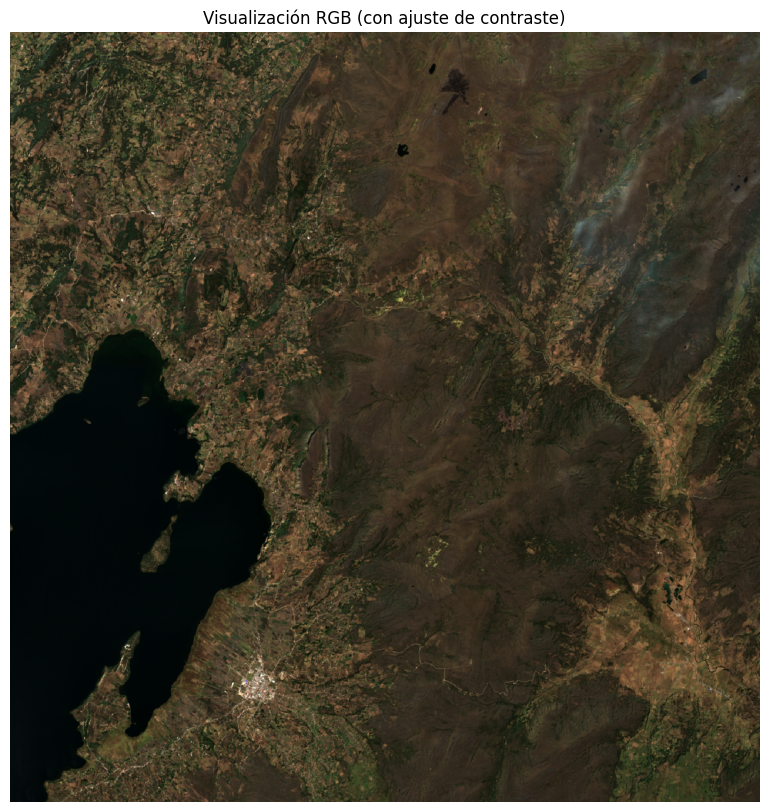

In [5]:
red = src.read(5)  # Banda 4 (Rojo)
green = src.read(4)  # Banda 3 (Verde)
blue = src.read(3)  # Banda 2 (Azul)

# Reemplazar valores no válidos (NaN o infinitos) por 0
red = np.nan_to_num(red, nan=0, posinf=0, neginf=0)
green = np.nan_to_num(green, nan=0, posinf=0, neginf=0)
blue = np.nan_to_num(blue, nan=0, posinf=0, neginf=0)

# Ajuste de contraste: Clipping a un rango adecuado para imágenes Sentinel-2
red = np.clip(red, 0, 0.3)
green = np.clip(green, 0, 0.3)
blue = np.clip(blue, 0, 0.3)

# Normalizar al rango [0, 255] y convertir a uint8
red = ((red / 0.3) * 255).astype(np.uint8)
green = ((green / 0.3) * 255).astype(np.uint8)
blue = ((blue / 0.3) * 255).astype(np.uint8)

# Crear una imagen RGB combinando las bandas
rgb_image = np.dstack((red, green, blue))

# Mostrar la imagen en RGB
plt.figure(figsize=(10, 10))
plt.imshow(rgb_image)
plt.axis('off')
plt.title("Visualización RGB (con ajuste de contraste)")
plt.show()

### NDWI

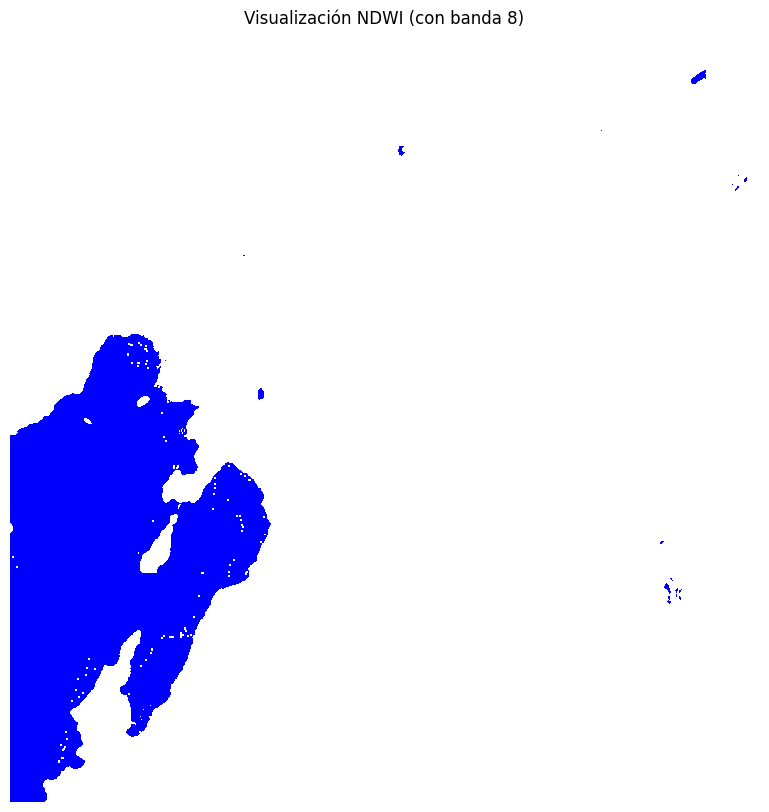

In [6]:
band1 = src.read(14)

# Colores para valores negativos y positivos
cmap = ListedColormap(["white", "blue"])

# Mostrar la banda en la escala especificada
plt.figure(figsize=(10, 10))
plt.imshow(band1, cmap=cmap, vmin=-1, vmax=1)
plt.title("Visualización NDWI (con banda 8)")
plt.axis('off')  # Opcional: Ocultar los ejes
plt.show()

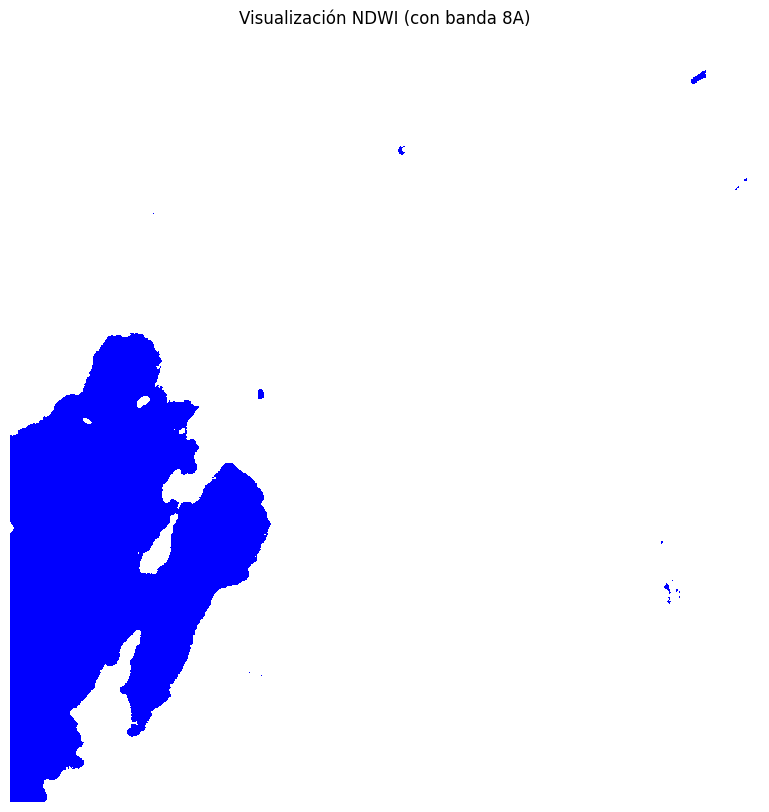

In [7]:
band1 = src.read(15)

# Colores para valores negativos y positivos
cmap = ListedColormap(["white", "blue"])

# Mostrar la banda en la escala especificada
plt.figure(figsize=(10, 10))
plt.imshow(band1, cmap=cmap, vmin=-1, vmax=1)
plt.title("Visualización NDWI (con banda 8A)")
plt.axis('off')  # Opcional: Ocultar los ejes
plt.show()

### Areas etiquetadas

In [8]:
etiquetas = src.read(1)

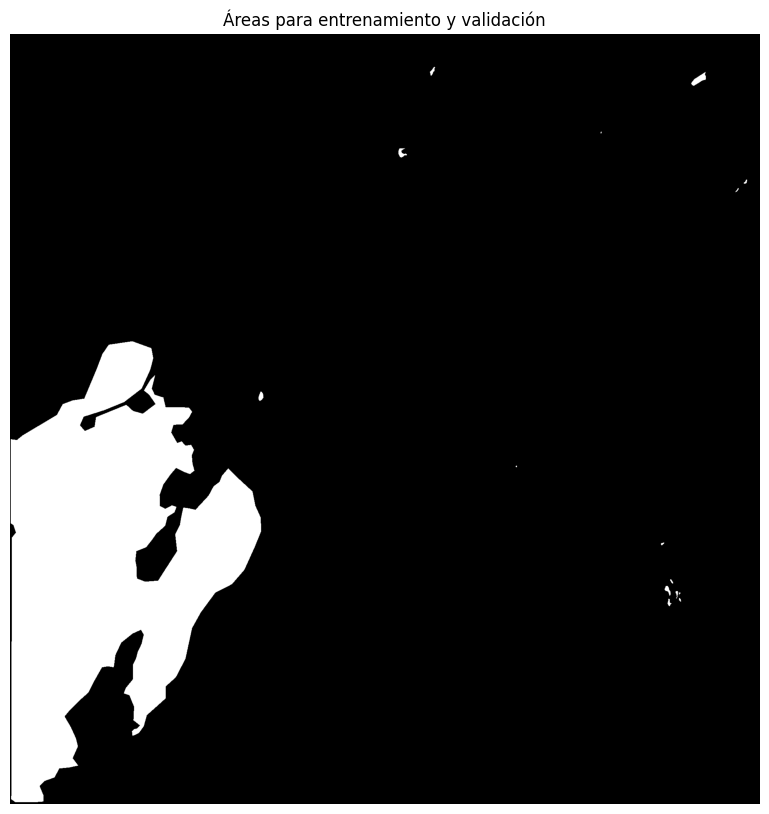

In [9]:
# Asignar un valor constante a todos los valores diferentes de 0
etiquetas_ = np.where(etiquetas > 0, 1, etiquetas)
# Visualizar la banda modificada en escala de grises
plt.figure(figsize=(10, 10))
plt.imshow(etiquetas_, cmap='gray')
plt.title("Áreas para entrenamiento y validación")
plt.axis('off')  # Opcional: Ocultar los ejes
plt.show()

## Preparación de los datos

In [10]:
ndwi_8 = src.read(14).flatten()  # NDWI banda 3 y 8
ndwi_8A = src.read(15).flatten()  # NDWI banda 3 y 8A
nir = src.read(9).flatten()  # Infrarrojo cercano (banda 8)
labels = src.read(1).flatten()  # Áreas de interés (etiquetas)
rojo = src.read(5).flatten() # Rojo

In [11]:
# Crear un DataFrame con las características y las etiquetas
df = pd.DataFrame({
    'NDWI_8': ndwi_8,
    'NDWI_8A': ndwi_8A,
    'NIR': nir,
    'rojo': rojo,
    'cuerpo_agua': labels,
})

In [12]:
df

NDWI_8   NDWI_8A     NIR    rojo  cuerpo_agua
0       -0.478222 -0.493316  0.3275  0.1334          0.0
1       -0.386788 -0.417316  0.3044  0.1442          0.0
2       -0.351905 -0.384941  0.3033  0.1424          0.0
3       -0.554120 -0.557249  0.3848  0.0986          0.0
4       -0.502843 -0.520658  0.3700  0.1198          0.0
...           ...       ...     ...     ...          ...
4265473 -0.512545 -0.545657  0.1266  0.0478          0.0
4265474 -0.515044 -0.543079  0.1284  0.0474          0.0
4265475 -0.509756 -0.550084  0.1238  0.0473          0.0
4265476 -0.538198 -0.547486  0.1349  0.0470          0.0
4265477 -0.530011 -0.541943  0.1351  0.0488          0.0

[4265478 rows x 5 columns]

In [13]:
df['cuerpo_agua'] = np.where(df['cuerpo_agua'] > 0, True, False)

In [14]:
df.head()

NDWI_8   NDWI_8A     NIR    rojo  cuerpo_agua
0 -0.478222 -0.493316  0.3275  0.1334        False
1 -0.386788 -0.417316  0.3044  0.1442        False
2 -0.351905 -0.384941  0.3033  0.1424        False
3 -0.554120 -0.557249  0.3848  0.0986        False
4 -0.502843 -0.520658  0.3700  0.1198        False

## Estadistica descriptiva

In [15]:
df.describe(percentiles=[0.01,.03,.05,.07,.08,.1,.2,.3,.4,.5,.6,.7,.8,.9,.95,.98,.99])

NDWI_8       NDWI_8A           NIR          rojo
count  4.265357e+06  4.265478e+06  4.265357e+06  4.265430e+06
mean  -3.831869e-01 -4.047592e-01  1.945302e-01  6.604386e-02
std    5.316266e-01  5.292269e-01  9.673476e-02  3.600921e-02
min   -1.229996e+02 -1.430002e+02 -9.990000e-02 -1.980000e-02
1%    -7.345735e-01 -7.518110e-01 -8.000000e-04  8.000000e-04
3%    -6.987096e-01 -7.165057e-01  1.100000e-03  2.000000e-03
5%    -6.781877e-01 -6.966658e-01  1.900000e-03  2.500000e-03
7%    -6.622313e-01 -6.816582e-01  2.600000e-03  2.800000e-03
8%    -6.553087e-01 -6.751701e-01  2.800000e-03  3.100000e-03
10%   -6.428794e-01 -6.635379e-01  3.400000e-03  3.700000e-03
20%   -5.979003e-01 -6.205688e-01  1.458000e-01  4.170000e-02
30%   -5.662393e-01 -5.896434e-01  1.606000e-01  5.240000e-02
40%   -5.398442e-01 -5.640301e-01  1.748000e-01  5.940000e-02
50%   -5.165395e-01 -5.411576e-01  1.909000e-01  6.570000e-02
60%   -4.950727e-01 -5.200000e-01  2.117000e-01  7.240000e-02
70%   -4.736351e-01 -4.986072e-01  2.388000e-01  8.020000e-02
80%   -4.444086e-01 -4.688593e-01  2.721000e-01  9.140000e-02
90%    5.185185e-01  5.070422e-01  3.168000e-01  1.102000e-01
95%    6.842105e-01  6.785714e-01  3.507000e-01  1.272000e-01
98%    9.111111e-01  9.151515e-01  3.855000e-01  1.470000e-01
99%    1.205882e+00  1.189189e+00  4.084000e-01  1.616000e-01
max    1.030002e+02  1.490002e+02  1.140900e+00  7.888000e-01

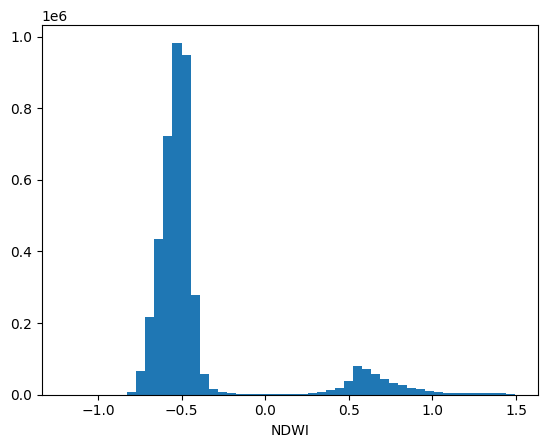

In [16]:
plt.hist(df[(df['NDWI_8']>-1.5) & (df['NDWI_8']<1.5)]['NDWI_8'], bins=50)
plt.xlabel('NDWI')
plt.show()

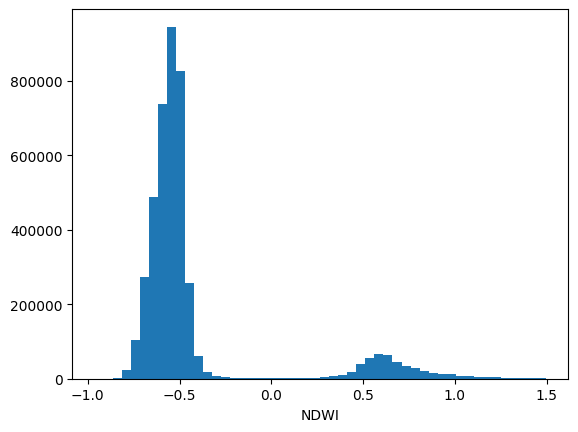

In [17]:
plt.hist(df[(df['NDWI_8A']>-1.5) & (df['NDWI_8A']<1.5)]['NDWI_8A'], bins=50)
plt.xlabel('NDWI')
plt.show()

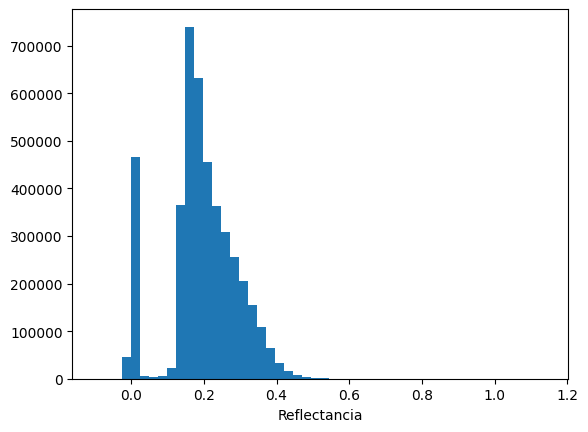

In [18]:
plt.hist(df['NIR'], bins=50)
plt.xlabel('Reflectancia')
plt.show()

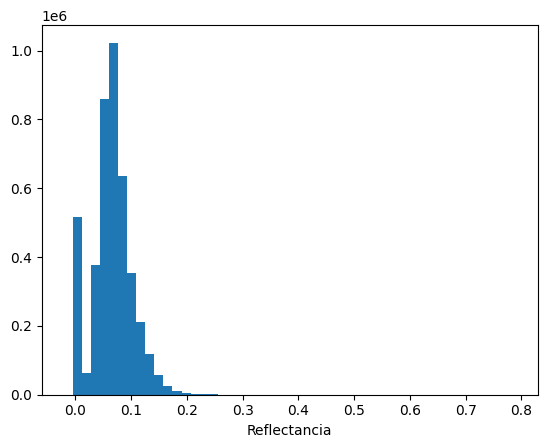

In [19]:
plt.hist(df['rojo'], bins=50)
plt.xlabel('Reflectancia')
plt.show()

In [20]:
df = df[(df['NDWI_8']>-1.5) & (df['NDWI_8']<1.5) & (df['NDWI_8A']>-1.5) & (df['NDWI_8A']<1.5)]

In [21]:
df.isna().sum()

NDWI_8          0
NDWI_8A         0
NIR             0
rojo           15
cuerpo_agua     0
dtype: int64

In [22]:
df.dropna(inplace=True)

/var/folders/kg/plkd97154_zf916xg8gj219h0000gn/T/ipykernel_85648/1379821321.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df.dropna(inplace=True)


In [23]:
df.describe()

NDWI_8       NDWI_8A           NIR          rojo
count  4.235166e+06  4.235166e+06  4.235166e+06  4.235166e+06
mean  -4.009998e-01 -4.226126e-01  1.959312e-01  6.651437e-02
std    3.979677e-01  4.029491e-01  9.563999e-02  3.570325e-02
min   -1.202867e+00 -9.615833e-01 -9.990000e-02 -1.980000e-02
25%   -5.816733e-01 -6.047285e-01  1.544000e-01  4.840000e-02
50%   -5.173077e-01 -5.419259e-01  1.916000e-01  6.600000e-02
75%   -4.627112e-01 -4.874569e-01  2.552000e-01  8.540000e-02
max    1.495413e+00  1.495049e+00  1.140900e+00  7.888000e-01

In [24]:
df[['NDWI_8', 'NDWI_8A', 'NIR', 'rojo']].corr()

NDWI_8   NDWI_8A       NIR      rojo
NDWI_8   1.000000  0.992280 -0.748462 -0.540621
NDWI_8A  0.992280  1.000000 -0.733472 -0.537103
NIR     -0.748462 -0.733472  1.000000  0.741659
rojo    -0.540621 -0.537103  0.741659  1.000000

## Muestreo aleatorio

### Visualizar algunas muestras seleccionadas aleatoriamente

In [33]:
n_sample =  300

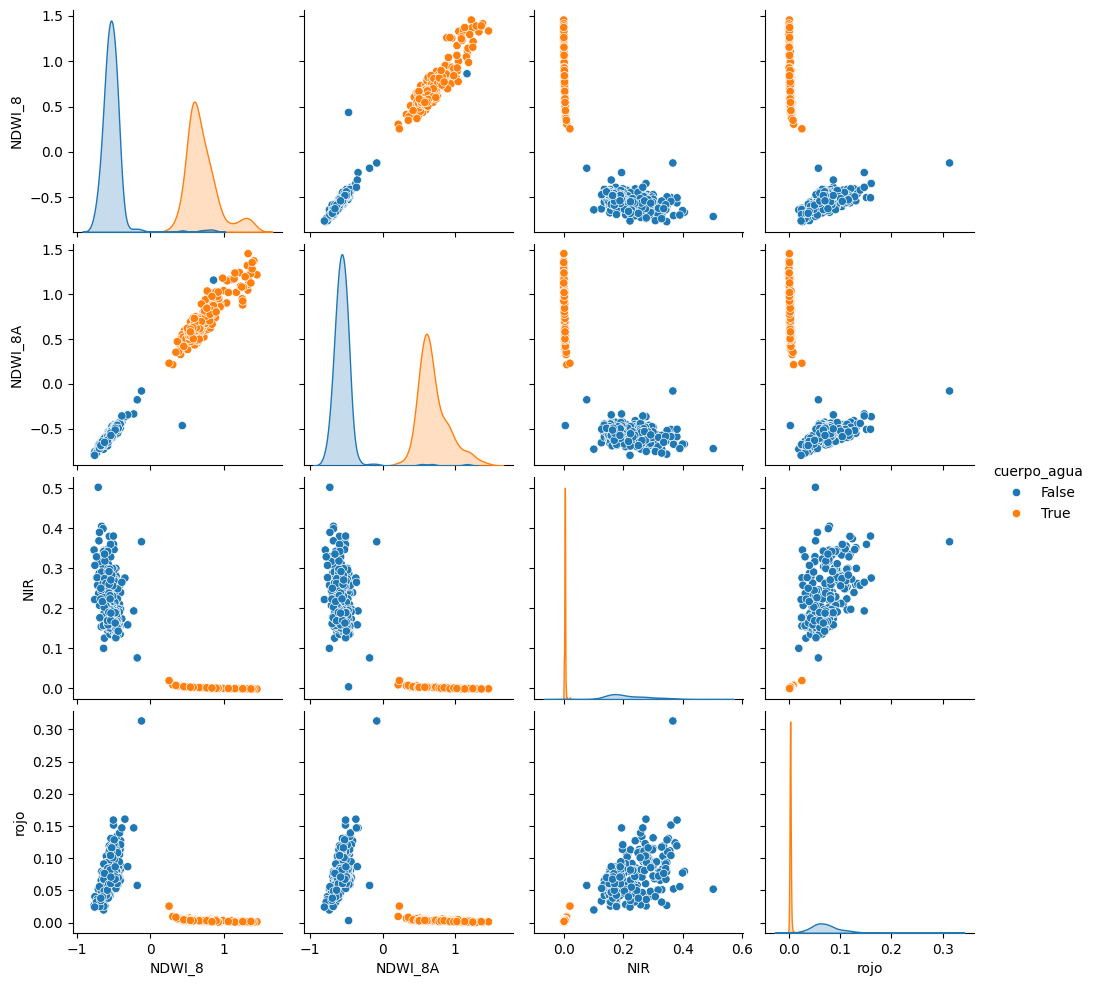

In [34]:
muestra =  pd.concat([
    df[df['cuerpo_agua'] == class_value].sample(n=n_sample, random_state=42, replace=False)
    for class_value in df['cuerpo_agua'].unique()
])
sns.pairplot(data=muestra, hue="cuerpo_agua")

### Datos para entrenamiento y validación
No entrenaremos con todos los datos, solo una "muestra representativa"

In [35]:
df['cuerpo_agua'].value_counts()

cuerpo_agua
False    3804159
True      431007
Name: count, dtype: int64

In [36]:
sample_size_per_class = 300000

In [37]:
df_sampled = pd.concat([
    df[df['cuerpo_agua'] == class_value].sample(n=sample_size_per_class, random_state=42, replace=False)
    for class_value in df['cuerpo_agua'].unique()
])

In [38]:
df_sampled['cuerpo_agua'].value_counts()

cuerpo_agua
False    300000
True     300000
Name: count, dtype: int64

## Datos de entrenamiento y validación

In [41]:
from sklearn.model_selection import train_test_split

In [42]:
X = df_sampled.drop(['cuerpo_agua', 'NDWI_8', 'NIR'], axis=1)  # Variables independientes
y = df_sampled['cuerpo_agua']               # Variable dependiente

# Dividir en entrenamiento y prueba
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.1, random_state=42) # stratify=y


In [43]:
X.head()

NDWI_8A    rojo
1127356 -0.582399  0.0676
921413  -0.591254  0.0505
2222111 -0.731323  0.0511
2218858 -0.556300  0.0516
2477911 -0.550267  0.0533

In [44]:
y_train.value_counts()

cuerpo_agua
False    270113
True     269887
Name: count, dtype: int64

## SVC

In [45]:
from sklearn.svm import SVC
from sklearn.metrics import accuracy_score, classification_report

In [46]:
svm_model = SVC(kernel='linear', random_state=42)

In [47]:
svm_model.fit(X_train, y_train)

SVC(kernel='linear', random_state=42)

In [48]:
y_pred = svm_model.predict(X_test)
accuracy = accuracy_score(y_test, y_pred)
report = classification_report(y_test, y_pred)

In [49]:
y_pred

array([False, False,  True, ...,  True, False, False])

In [50]:
print("Exactitud del modelo SVM:", accuracy)
print("\nReporte de clasificación:\n", report)

Exactitud del modelo SVM: 0.99375

Reporte de clasificación:
               precision    recall  f1-score   support

       False       1.00      0.99      0.99     29887
        True       0.99      1.00      0.99     30113

    accuracy                           0.99     60000
   macro avg       0.99      0.99      0.99     60000
weighted avg       0.99      0.99      0.99     60000



### Frontera de decision

In [51]:
from sklearn.inspection import DecisionBoundaryDisplay

In [58]:
n_samples = 100

In [59]:
sample_indices = np.random.choice(X_train.index, n_samples, replace=False)
X_sample = X_train.loc[sample_indices, ['NDWI_8A', 'rojo']]
y_sample = y_train.loc[sample_indices]

<Figure size 1000x600 with 0 Axes>

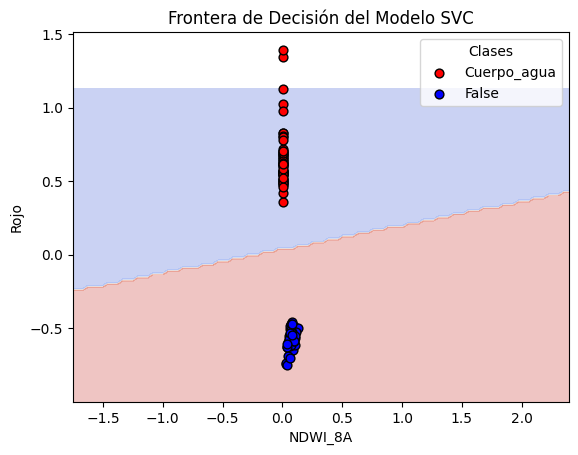

In [60]:
# Usar DecisionBoundaryDisplay para graficar la frontera de decisión
plt.figure(figsize=(10, 6))
DecisionBoundaryDisplay.from_estimator(svm_model, X_sample, response_method="predict", cmap='coolwarm', alpha=0.3)

# Graficar los puntos de datos
# Graficar los puntos de datos de cada clase con etiquetas
plt.scatter(X_sample[y_sample == True]['rojo'], X_sample[y_sample == True]['NDWI_8A'],
            color='red', edgecolor='k', s=40, label='Cuerpo_agua')
plt.scatter(X_sample[y_sample == False]['rojo'], X_sample[y_sample == False]['NDWI_8A'],
            color='blue', edgecolor='k', s=40, label='False')
plt.xlabel('NDWI_8A')
plt.ylabel('Rojo')
plt.title('Frontera de Decisión del Modelo SVC')
plt.legend(title="Clases", loc="upper right") 
plt.show()

### Guardar el modelo

In [61]:
import joblib

In [62]:
# Guardar el modelo en un archivo
joblib.dump(svm_model, './data/svm_model.pkl')

['./data/svm_model.pkl']

### Predicción sobre una nueva imagen

In [63]:
# Cargar el archivo TIFF Sentinel 2
file_path = './data/new_data_combinado_1.tif'
src_new = rasterio.open(file_path)

In [64]:
red = src_new.read(4)  # Banda 4 (Rojo)
green = src_new.read(3)  # Banda 3 (Verde)
blue = src_new.read(2)  # Banda 2 (Azul)

In [65]:
red.max(), red.min(), red.mean()

(nan, nan, nan)

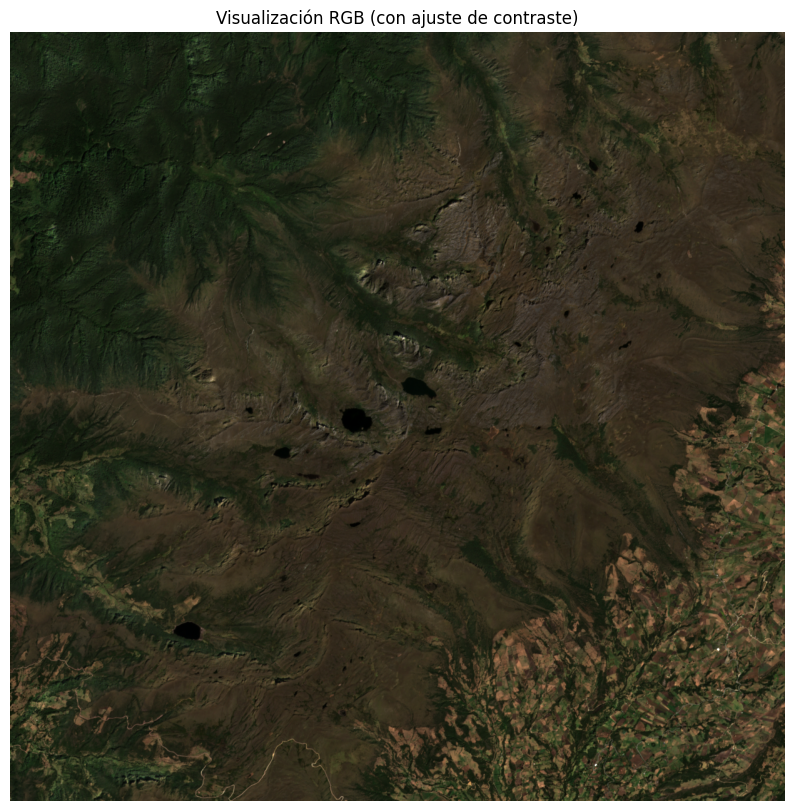

In [66]:
# Reemplazar valores no válidos (NaN o infinitos) por 0
red = np.nan_to_num(red, nan=0, posinf=0, neginf=0)
green = np.nan_to_num(green, nan=0, posinf=0, neginf=0)
blue = np.nan_to_num(blue, nan=0, posinf=0, neginf=0)

# Ajuste de contraste: Clipping a un rango adecuado para imágenes Sentinel-2
red = np.clip(red, 0, 0.3)
green = np.clip(green, 0, 0.3)
blue = np.clip(blue, 0, 0.3)

# Normalizar al rango [0, 255] y convertir a uint8
red = ((red / 0.3) * 255).astype(np.uint8)
green = ((green / 0.3) * 255).astype(np.uint8)
blue = ((blue / 0.3) * 255).astype(np.uint8)

# Crear una imagen RGB combinando las bandas
rgb_image = np.dstack((red, green, blue))

# Mostrar la imagen en RGB
plt.figure(figsize=(10, 10))
plt.imshow(rgb_image)
plt.axis('off')
plt.title("Visualización RGB (con ajuste de contraste)")
plt.show()

In [67]:
# Leer las bandas necesarias y mantener la estructura 2D
ndwi_8A_new = src_new.read(14)  # NDWI banda 3 y 8A
rojo_new = src_new.read(4)      # Rojo


# Inicializar la matriz de salida con ceros y con la misma forma que la imagen original
predicted_image = np.zeros(ndwi_8A_new.shape, dtype=np.uint8)  # Usamos uint8 porque solo queremos 0 y 1

# Recorrer cada pixel y aplicar las condiciones
for i in range(ndwi_8A_new.shape[0]):
    for j in range(ndwi_8A_new.shape[1]):
        ndwi_value = ndwi_8A_new[i, j]
        rojo_value = rojo_new[i, j]
        
        # Solo predecir si los valores son finitos y están en el rango especificado
        # if not np.isnan(ndwi_value) and -1.5 < ndwi_value < 1.5:
        if np.isfinite(ndwi_value) and np.isfinite(rojo_value) and -1.5 < ndwi_value < 1.5:
            # Realizar la predicción
            input_data = pd.DataFrame([[ndwi_value, rojo_value]], columns=['NDWI_8A', 'rojo'])
            prediction = svm_model.predict(input_data)[0]
            
            # Convertir True/False a 1/0 y asignar al pixel en predicted_image
            predicted_image[i, j] = 1 if prediction else 0

# Guardar la imagen predicha como un archivo .tif georreferenciado
metadata = src_new.meta.copy()
metadata.update({
    'count': 1,             # Solo una banda de predicción
    'dtype': 'uint8',       # Usamos uint8 ya que solo necesitamos 0 o 1
})

output_path = './data/new_data1_combinada_out.tif'
with rasterio.open(output_path, 'w', **metadata) as dst:
    dst.write(predicted_image, 1)

# Cerrar el archivo de entrada
src_new.close()

### Inferencia con el modelo guardado

In [52]:
svm_model_s = joblib.load('./data/svm_model.pkl')

In [53]:
# Cargar el archivo TIFF Sentinel 2
file_path = './data/new_data_combinado_2.tif'
src_new = rasterio.open(file_path)

In [54]:
red = src_new.read(4)  # Banda 4 (Rojo)
green = src_new.read(3)  # Banda 3 (Verde)
blue = src_new.read(2) # Banda 2 (Azul)

In [55]:
red.min(), red.max(), red.mean()

(nan, nan, nan)

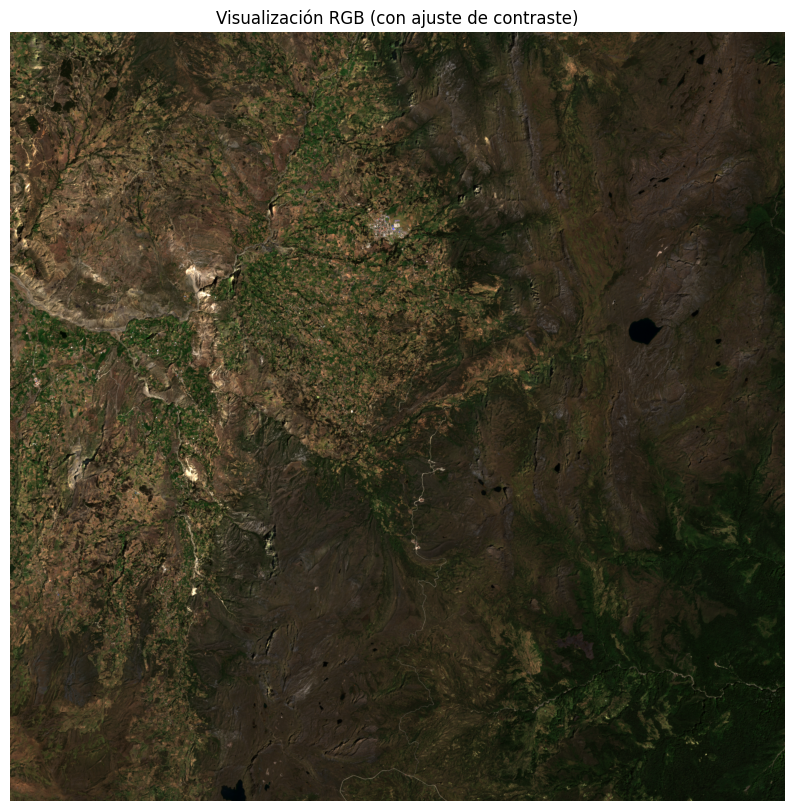

In [56]:

# Reemplazar valores no válidos (NaN o infinitos) por 0
red = np.nan_to_num(red, nan=0, posinf=0, neginf=0)
green = np.nan_to_num(green, nan=0, posinf=0, neginf=0)
blue = np.nan_to_num(blue, nan=0, posinf=0, neginf=0)

# Ajuste de contraste: Clipping a un rango adecuado para imágenes Sentinel-2
red = np.clip(red, 0, 0.3)
green = np.clip(green, 0, 0.3)
blue = np.clip(blue, 0, 0.3)

# Normalizar al rango [0, 255] y convertir a uint8
red = ((red / 0.3) * 255).astype(np.uint8)
green = ((green / 0.3) * 255).astype(np.uint8)
blue = ((blue / 0.3) * 255).astype(np.uint8)

# Crear una imagen RGB combinando las bandas
rgb_image = np.dstack((red, green, blue))

# Mostrar la imagen en RGB
plt.figure(figsize=(10, 10))
plt.imshow(rgb_image)
plt.axis('off')
plt.title("Visualización RGB (con ajuste de contraste)")
plt.show()

In [57]:
# Leer las bandas necesarias y mantener la estructura 2D
ndwi_8A_new = src_new.read(14)  # NDWI banda 3 y 8A
rojo_new = src_new.read(4)      # Rojo


# Inicializar la matriz de salida con ceros y con la misma forma que la imagen original
predicted_image = np.zeros(ndwi_8A_new.shape, dtype=np.uint8)  # Usamos uint8 porque solo queremos 0 y 1

# Recorrer cada pixel y aplicar las condiciones
for i in range(ndwi_8A_new.shape[0]):
    for j in range(ndwi_8A_new.shape[1]):
        ndwi_value = ndwi_8A_new[i, j]
        rojo_value = rojo_new[i, j]
        
        # Solo predecir si los valores son finitos y están en el rango especificado
        if np.isfinite(ndwi_value) and np.isfinite(rojo_value) and -1.5 < ndwi_value < 1.5:
            # Realizar la predicción
            input_data = pd.DataFrame([[ndwi_value, rojo_value]], columns=['NDWI_8A', 'rojo'])
            prediction = svm_model_s.predict(input_data)[0]
            
            # Convertir True/False a 1/0 y asignar al pixel en predicted_image
            predicted_image[i, j] = 1 if prediction else 0

# Guardar la imagen predicha como un archivo .tif georreferenciado
metadata = src_new.meta.copy()
metadata.update({
    'count': 1,             # Solo una banda de predicción
    'dtype': 'uint8',       # Usamos uint8 ya que solo necesitamos 0 o 1
})

output_path = './data/new_data2_combinada_out.tif'
with rasterio.open(output_path, 'w', **metadata) as dst:
    dst.write(predicted_image, 1)

# Cerrar el archivo de entrada
src_new.close()

## Aprendizaje No supervisado

### Caracteristicas

In [58]:
n_sample =  1300

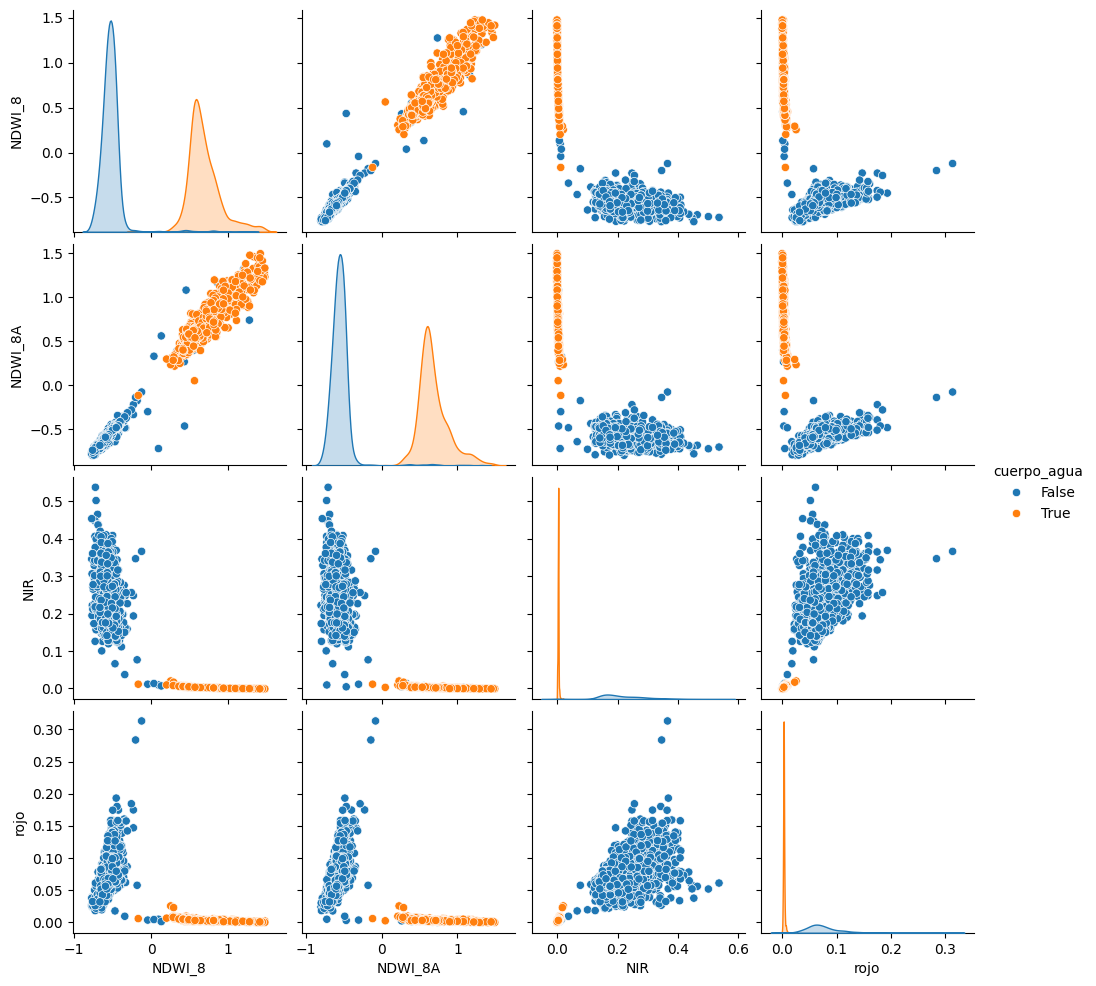

In [59]:
muestra =  pd.concat([
    df[df['cuerpo_agua'] == class_value].sample(n=n_sample, random_state=42, replace=False)
    for class_value in df['cuerpo_agua'].unique()
])
sns.pairplot(data=muestra, hue="cuerpo_agua")

### K-MEANS

#### Caracteristicas a emplear

In [60]:
n_sample = 15000
X = df.sample(n=n_sample, random_state=42, replace=False)

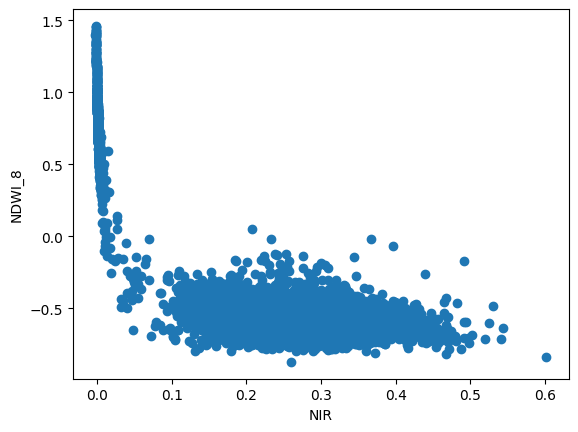

In [61]:
plt.scatter(X['NIR'], X['NDWI_8'])
plt.xlabel('NIR')
plt.ylabel('NDWI_8')
plt.show()

In [62]:
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_samples, silhouette_score

#### Seleccionar el número de clusters

In [63]:
X_sample = X[['NIR','NDWI_8']]

Para n_clusters = 2, el promedio del coeficiente de silueta es: 0.8848


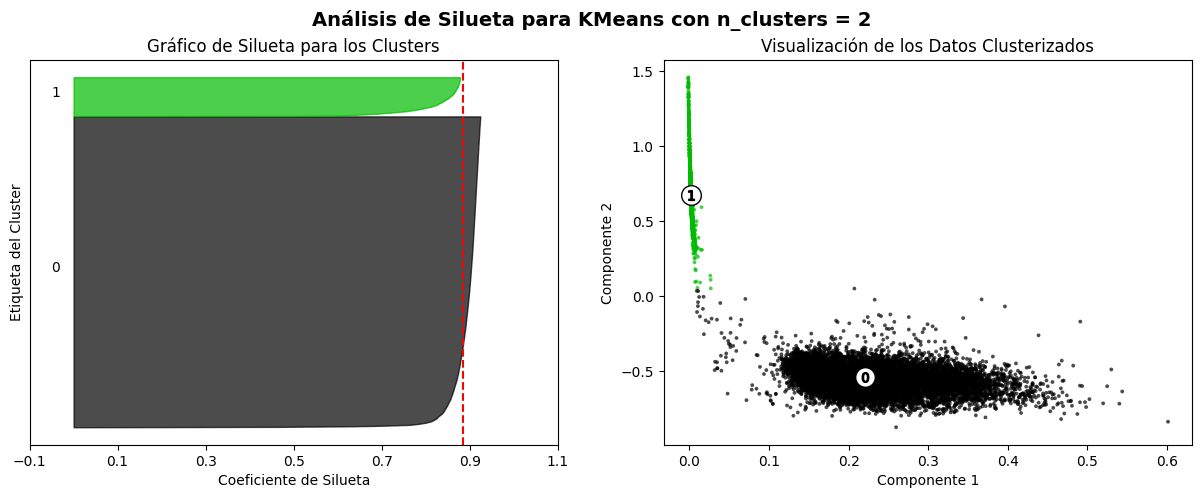

Para n_clusters = 3, el promedio del coeficiente de silueta es: 0.8548


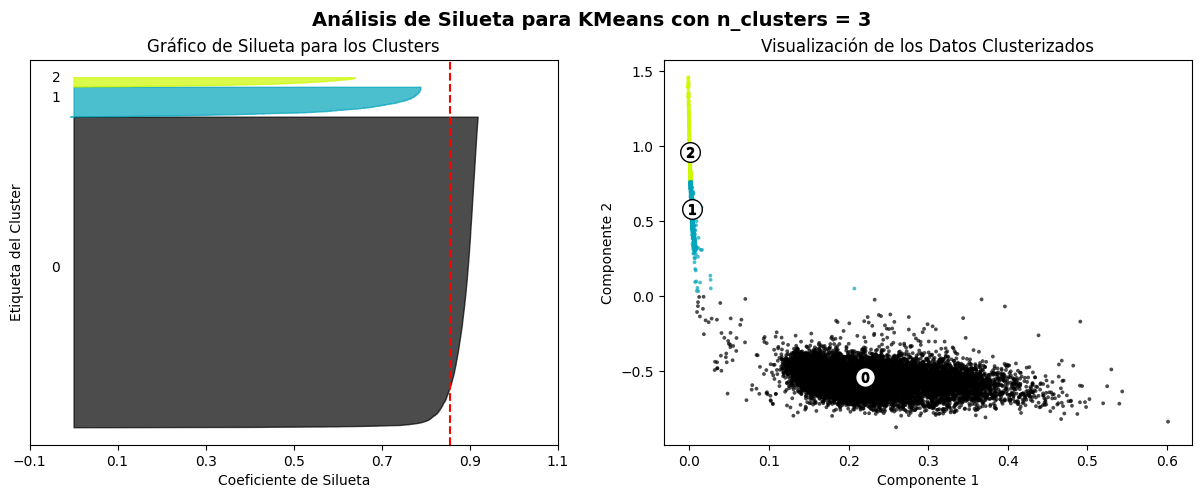

Para n_clusters = 4, el promedio del coeficiente de silueta es: 0.4428


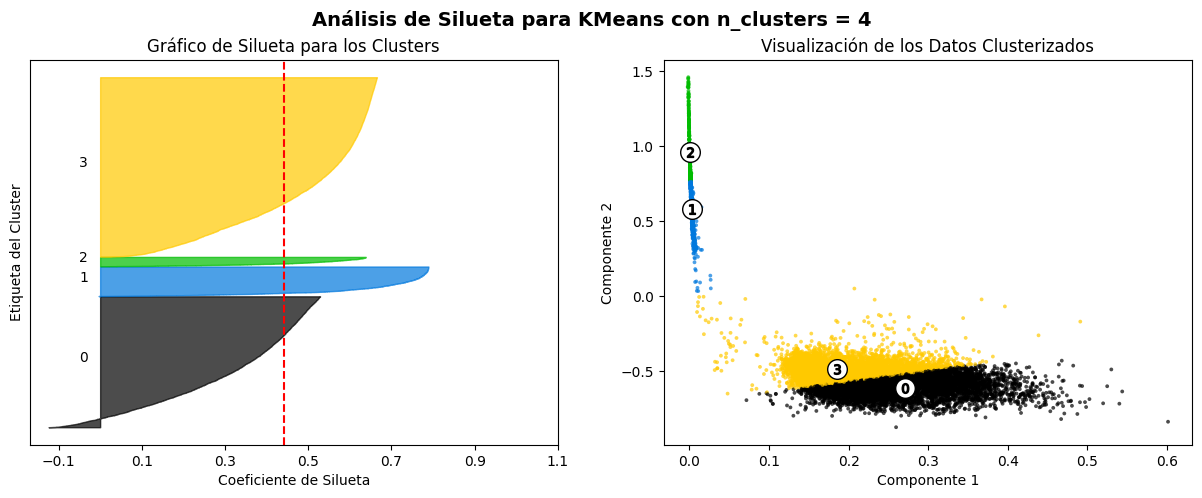

Para n_clusters = 5, el promedio del coeficiente de silueta es: 0.4355


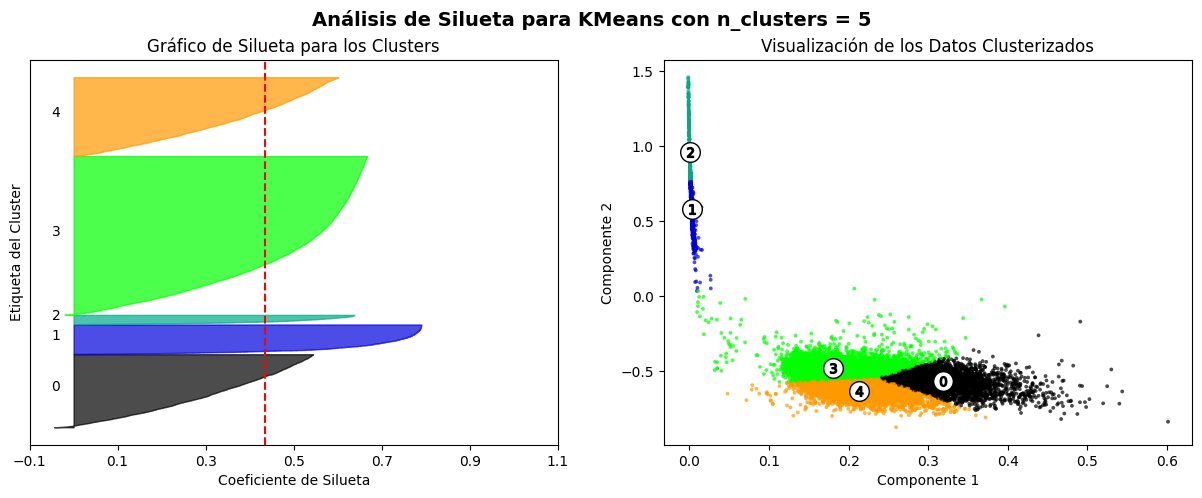

Para n_clusters = 6, el promedio del coeficiente de silueta es: 0.4256


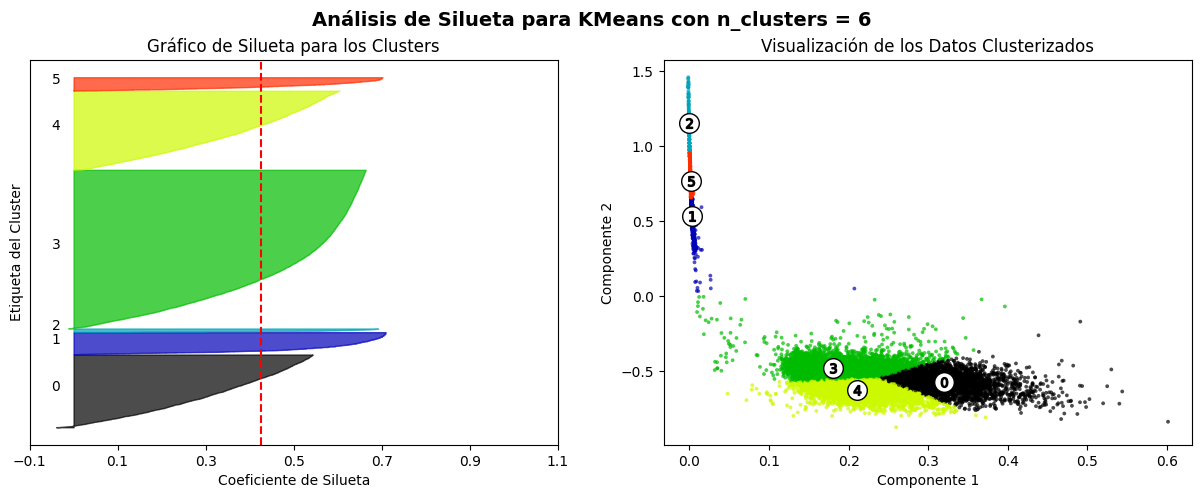

In [64]:
# Convierte el DataFrame a un array de NumPy para compatibilidad con scikit-learn
X_array = X_sample.to_numpy()

range_n_clusters = [2, 3, 4, 5, 6]

for n_clusters in range_n_clusters:
    # Crear una figura con dos subgráficos
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 5))
    fig.suptitle(f"Análisis de Silueta para KMeans con n_clusters = {n_clusters}", fontsize=14, fontweight='bold')

    # Inicializar el clusterizador con n_clusters
    clusterer = KMeans(n_clusters=n_clusters, random_state=42)
    cluster_labels = clusterer.fit_predict(X_array)

    # Calcular el promedio del coeficiente de silueta para todas las muestras
    silhouette_avg = silhouette_score(X_array, cluster_labels)
    print(f"Para n_clusters = {n_clusters}, el promedio del coeficiente de silueta es: {silhouette_avg:.4f}")

    # Calcular el coeficiente de silueta para cada muestra
    sample_silhouette_values = silhouette_samples(X_array, cluster_labels)

    y_lower = 10  # Inicializar la posición inferior para el gráfico de silueta
    for i in range(n_clusters):
        # Agregar los coeficientes de silueta para el cluster i y ordenarlos
        ith_cluster_silhouette_values = sample_silhouette_values[cluster_labels == i]
        ith_cluster_silhouette_values.sort()

        size_cluster_i = ith_cluster_silhouette_values.shape[0]
        y_upper = y_lower + size_cluster_i

        color = plt.cm.nipy_spectral(float(i) / n_clusters)
        ax1.fill_betweenx(np.arange(y_lower, y_upper), 0, ith_cluster_silhouette_values,
                          facecolor=color, edgecolor=color, alpha=0.7)

        # Etiquetar el gráfico de silueta con el número del cluster en el medio
        ax1.text(-0.05, y_lower + 0.5 * size_cluster_i, str(i))

        # Calcular la nueva posición inferior para el siguiente gráfico
        y_lower = y_upper + 10  # 10 para el espacio en blanco entre gráficos

    ax1.set_title("Gráfico de Silueta para los Clusters")
    ax1.set_xlabel("Coeficiente de Silueta")
    ax1.set_ylabel("Etiqueta del Cluster")
    ax1.axvline(x=silhouette_avg, color="red", linestyle="--")
    ax1.set_yticks([])  # Limpiar las etiquetas del eje y
    ax1.set_xticks(np.arange(-0.1, 1.1, 0.2))

    # Gráfico de dispersión de los datos con los clusters
    colors = plt.cm.nipy_spectral(cluster_labels.astype(float) / n_clusters)
    ax2.scatter(X_array[:, 0], X_array[:, 1], marker='.', s=30, lw=0, alpha=0.7, c=colors, edgecolor='k')

    # Dibujar círculos blancos en los centroides de los clusters
    centers = clusterer.cluster_centers_
    ax2.scatter(centers[:, 0], centers[:, 1], marker='o', c="white", alpha=1, s=200, edgecolor='k')

    for i, c in enumerate(centers):
        ax2.scatter(c[0], c[1], marker=f'${i}$', alpha=1, s=50, edgecolor='k')

    ax2.set_title("Visualización de los Datos Clusterizados")
    ax2.set_xlabel("Componente 1")
    ax2.set_ylabel("Componente 2")

    plt.show()

#### Clasificar sobre una imagen

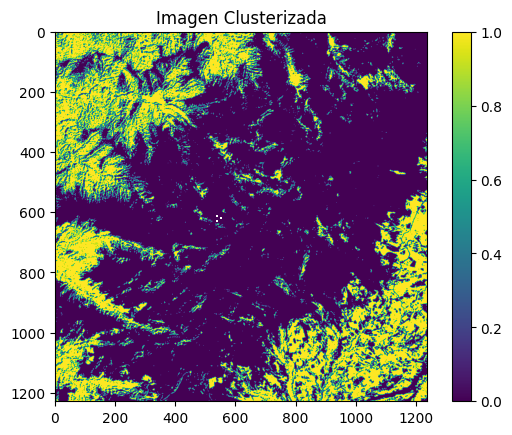

In [65]:
# Ruta del archivo de la imagen satelital
input_path = './data/new_data_combinado_1.tif'

# Leer las bandas necesarias y mantener la estructura 2D
with rasterio.open(input_path) as src:
    band1 = src.read(4)  # Banda 3
    band2 = src.read(8)  # Banda 8
    profile = src.profile

# Asegurarse de que las bandas tengan las mismas dimensiones
assert band1.shape == band2.shape, "Las bandas deben tener las mismas dimensiones"

# Preparar los datos para K-means
# Aplanar las bandas y combinar en una matriz de características
rows, cols = band1.shape
stacked_data = np.stack((band1.flatten(), band2.flatten()), axis=1)

# Manejar valores no finitos
mask = np.all(np.isfinite(stacked_data), axis=1)
stacked_data = stacked_data[mask]

# Aplicar K-means
kmeans = KMeans(n_clusters=2, random_state=42)
kmeans.fit(stacked_data)
labels = kmeans.labels_

# Crear una imagen de salida con las etiquetas de los clusters
clustered_image = np.full(band1.size, np.nan)
clustered_image[mask] = labels
clustered_image = clustered_image.reshape(rows, cols)

# Guardar la imagen clusterizada como un archivo .tif georreferenciado
output_path = './data/new_data_combinado_1_cluster.tif'
profile.update(
    dtype=rasterio.float32,
    count=1,
    compress='lzw'
)

with rasterio.open(output_path, 'w', **profile) as dst:
    dst.write(clustered_image.astype(rasterio.float32), 1)

# Opcional: Visualizar la imagen clusterizada
plt.imshow(clustered_image, cmap='viridis')
plt.title('Imagen Clusterizada')
plt.colorbar()
plt.show()

### DBSCAN

In [66]:
from sklearn.metrics import silhouette_score, silhouette_samples
from sklearn.cluster import DBSCAN
from sklearn.preprocessing import StandardScaler

In [67]:
n_sample = 13500
X = df.sample(n=n_sample, random_state=42, replace=False)

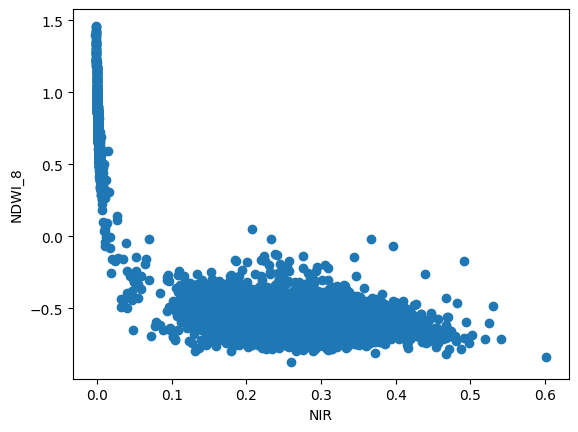

In [68]:
plt.scatter(X['NIR'], X['NDWI_8'])
plt.xlabel('NIR')
plt.ylabel('NDWI_8')
plt.show()

In [69]:
X_sample = X[['NIR','NDWI_8']]

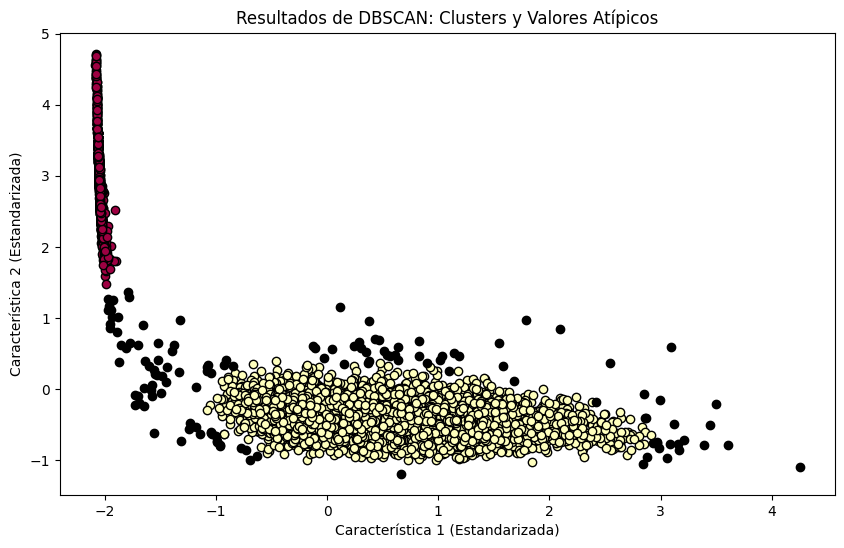

In [70]:
# Convierte el DataFrame a un array de NumPy para compatibilidad con scikit-learn
X_array = X_sample.to_numpy()

# Escalar los datos (opcional pero recomendado para DBSCAN)
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X_array)

# Aplicar DBSCAN
dbscan = DBSCAN(eps=0.2, min_samples=15, metric='manhattan')
labels = dbscan.fit_predict(X_scaled)

# Identificar puntos de ruido y clusters
unique_labels = set(labels)
colors = [plt.cm.Spectral(each) for each in np.linspace(0, 1, len(unique_labels))]

# Crear la figura para la visualización
plt.figure(figsize=(10, 6))

# Graficar los clusters
for k, col in zip(unique_labels, colors):
    if k == -1:
        # Color negro para el ruido
        col = [0, 0, 0, 1]

    class_member_mask = (labels == k)
    
    # Graficar los puntos que pertenecen al cluster k
    xy = X_scaled[class_member_mask]
    plt.plot(xy[:, 0], xy[:, 1], 'o', markerfacecolor=tuple(col),
             markeredgecolor='k', markersize=6)

# Etiquetas y título
plt.title("Resultados de DBSCAN: Clusters y Valores Atípicos")
plt.xlabel("Característica 1 (Estandarizada)")
plt.ylabel("Característica 2 (Estandarizada)")
plt.show()

#### Conteo de grupos

In [3]:
file_path = './data/new_data1_combinada_out.tif'
src = rasterio.open(file_path)

In [4]:
# Obtener dimensiones del archivo
width = src.width
height = src.height
bands = src.count

# Imprimir las dimensiones y el número de bandas
print(f"Dimensiones datos (ancho x alto): {width} x {height}")
print(f"Número de bandas: {bands}")

Dimensiones datos (ancho x alto): 1239 x 1229
Número de bandas: 1


In [5]:
clasificado = src.read(1)

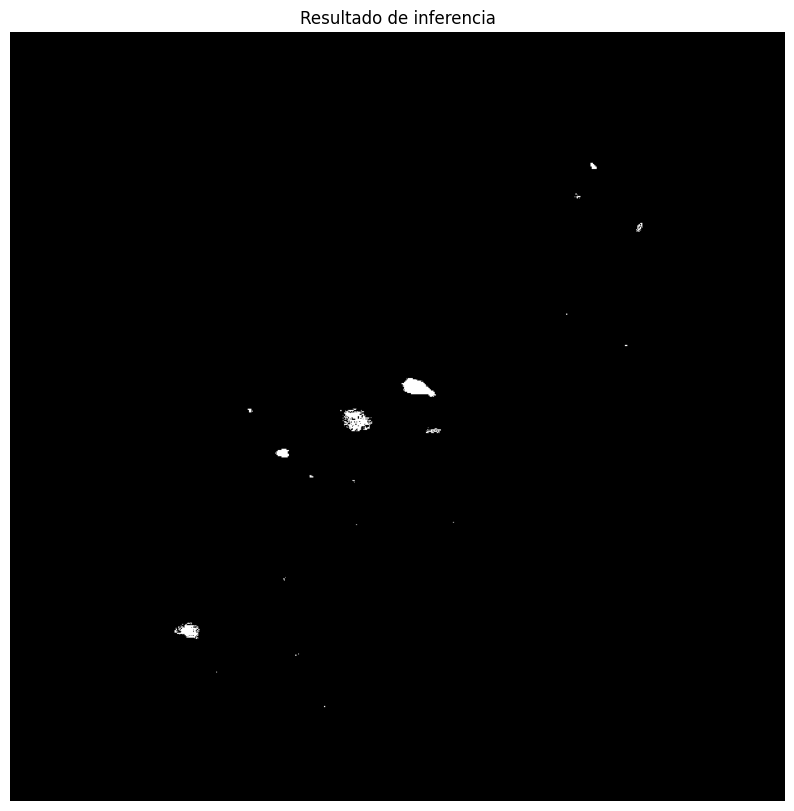

In [8]:
# Asignar un valor constante a todos los valores diferentes de 0
clasificado_ = np.where(clasificado > 0, 1, clasificado)
# Visualizar la banda modificada en escala de grises
plt.figure(figsize=(10, 10))
plt.imshow(clasificado_, cmap='gray')
plt.title("Resultado de inferencia")
plt.axis('off')  # Opcional: Ocultar los ejes
plt.show()

In [ ]:
# Verificando el contenido de la capa
unique_values = np.unique(clasificado)
print(f"Valores únicos en la capa cargada: {unique_values}")


Valores únicos en la capa cargada: [0 1]


In [ ]:
# Preparar datos para DBSCAN: Coordenadas de los píxeles de cuerpos de agua (valor 1)
pixel_coords = np.array(np.where(clasificado == 1)).T

In [14]:
if pixel_coords.shape[0] == 0:
    print("No se encontraron píxeles de cuerpos de agua (valor 1) para agrupar.")
    num_clusters_found = 0
else:
    # 3. Ejecutar DBSCAN
    # Parámetros clave para DBSCAN:
    # eps: La distancia máxima entre dos píxeles para ser considerados vecinos.
    # min_samples: El número mínimo de píxeles (cuerpos de agua) para formar un clúster denso.
    
    eps_val = 1.5 
    min_samples_val = 5 

    dbscan = DBSCAN(eps=eps_val, min_samples=min_samples_val)
    cluster_labels = dbscan.fit_predict(pixel_coords)
    # Contar el numero de clusters
    unique_labels = set(cluster_labels)
    num_clusters_found = len(unique_labels) - (1 if -1 in unique_labels else 0)
    print(f"Número de grupos de cuerpos de agua encontrados por DBSCAN: {num_clusters_found}")
    print(f" (Usando eps={eps_val}, min_samples={min_samples_val})")
    print(f"Etiquetas de clúster generadas (incluye -1 para ruido): {np.unique(cluster_labels)}")

Número de grupos de cuerpos de agua encontrados por DBSCAN: 19
 (Usando eps=1.5, min_samples=5)
Etiquetas de clúster generadas (incluye -1 para ruido): [-1  0  1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18]


/var/folders/kg/plkd97154_zf916xg8gj219h0000gn/T/ipykernel_31208/3756310266.py:17: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed in 3.11. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap()`` or ``pyplot.get_cmap()`` instead.
  cmap = plt.cm.get_cmap('nipy_spectral', len(unique_labels))


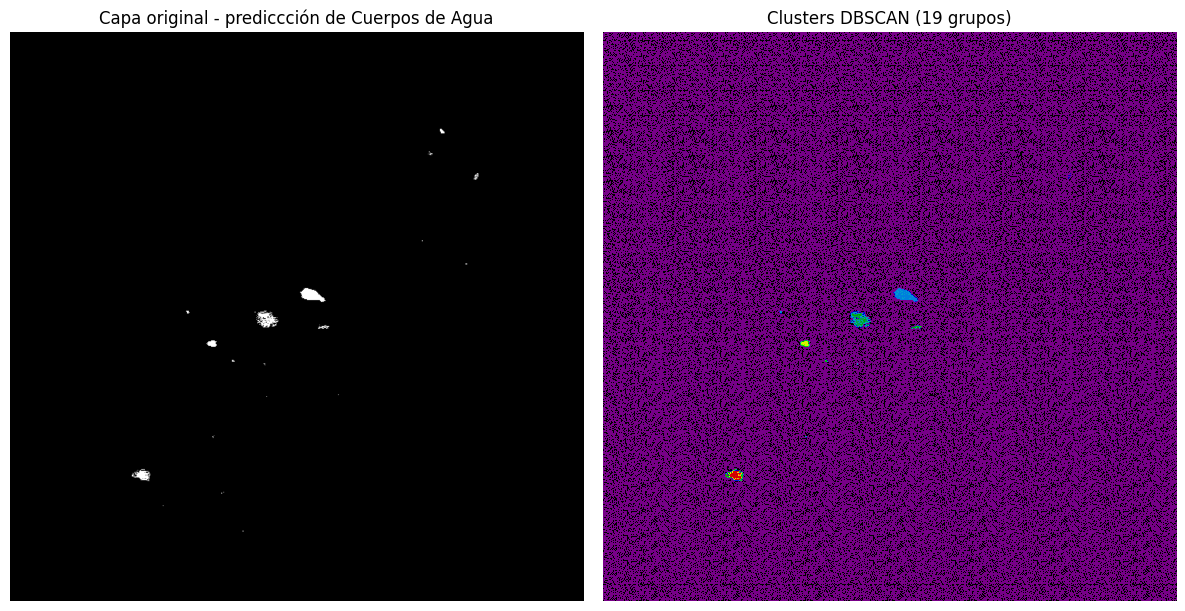

In [18]:
# Visualizar los resultados
output_image = np.zeros_like(clasificado, dtype=float)
for i, (r, c) in enumerate(pixel_coords):
    if cluster_labels[i] == -1:
        output_image[r, c] = -1 # Ruido
    else:
        output_image[r, c] = cluster_labels[i] + 1 # Clústeres desde 1

plt.figure(figsize=(12, 6))
plt.subplot(1, 2, 1)
plt.imshow(clasificado, cmap='gray')
plt.title('Capa original - prediccción de Cuerpos de Agua')
plt.axis('off')

plt.subplot(1, 2, 2)
if num_clusters_found > 0 or -1 in unique_labels : # Solo si hay algo que mostrar con colores
    cmap = plt.cm.get_cmap('nipy_spectral', len(unique_labels))
else: # Si no hay clusters ni ruido, usa gris
    cmap = 'gray'
plt.imshow(output_image, cmap=cmap, vmin=-1, vmax=len(unique_labels)-1 if -1 in unique_labels else len(unique_labels)) # Ajustar vmin/vmax
plt.title(f'Clusters DBSCAN ({num_clusters_found} grupos)')
plt.axis('off')

plt.tight_layout()
plt.show()